# Lab #7: Non-Linear Models for Regression
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2019

<img src="fig/logos.jpg" style="height:150px;">

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        if reg_param is None:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                sum_error = np.sum(squared_error)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if (iteration % self.check_point == 0) & (iteration > 0):
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

## Problem Description: Non-linear Models for Regression

From Lecture #14, we've seen that we can take our favourite generalized linear models and replace the linear function $\mathbf{w}^\top \mathbf{X}$ with $g_{\mathbf{W}}(\mathbf{X})$, where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$. The advantage of using neural networks to represent non-linear function is that neural networks allows us to build up complex non-linear functions very cheaply and quicklly through composition of simple functions. A neural network $g_{\mathbf{W}}$ with a fixed architecture can approximate a wide range of different functions.

In this lab, we compare fitting neural networks regression models with polynomial regression models.

### Part I. Small Data Set
Read in the data in `lab_7_data.csv` (this is the same dataset used in HW#7). 

1. (**Learning the Model**) Fit 100 different MLE neural network models (with the given architecture or your own choice) on this data. The data is small so don't bootstrap, rather, initialize your network parameters randomly for each fit. <br><br>

2. (**Model Evaluation**) Compute the average log-likelihood of the observed data over these 1000 MLE models.<br><br>

3. (**Model Evaluation**) Visualize the predictive distributions of your 1000 MLE models (i.e. use them to predict on a range of uniformly spaced values from [-8, 8] and then plot either the 95% predictive interval or plot all the models as lines).<br><br>

4. (**Compare with Polynomial Regression**) Do the above for polynomial models with polynomial degree 7. Which model class (polynomial or neural network) is a better fit for the data? Which model class produces better aleotoric uncertainty? Which model class prodcues better epistemic uncertainty? Why?

## Example of Fitting One NN to the Data

In [3]:
data = pd.read_csv('lab_7_data.csv')
x = data['x'].values
y = data['y'].values
data.head()

,x,y
0,-6.0,-3.380284
1,-5.6,-2.892117
2,-5.2,-2.690059
3,-4.8,-2.040000
4,-4.4,-1.399942


In [4]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [7]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':4000, 
          'random_restarts':1, 
          'check_point':200}

#fit my neural network to minimize MSE on the given data
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

Iteration 200 lower bound 4.7417770474922785; gradient mag: 3.5878302150194825
Iteration 400 lower bound 3.763760619716274; gradient mag: 2.941313118378996
Iteration 600 lower bound 2.964891126920991; gradient mag: 2.4696108679242834
Iteration 800 lower bound 2.329703188498748; gradient mag: 2.0663648966446284
Iteration 1000 lower bound 1.8459856639263232; gradient mag: 1.6940120855377858
Iteration 1200 lower bound 1.4976254439792949; gradient mag: 1.3491032022279879
Iteration 1400 lower bound 1.2624898963325641; gradient mag: 1.0405421588923827
Iteration 1600 lower bound 1.114721923758202; gradient mag: 0.7777490552927369
Iteration 1800 lower bound 1.0285904824812797; gradient mag: 0.5629319969280473
Iteration 2000 lower bound 0.9818811848193401; gradient mag: 0.39844775732974874
Iteration 2200 lower bound 0.95788865828741; gradient mag: 0.2790683847598746
Iteration 2400 lower bound 0.9457231314342398; gradient mag: 0.19626127286449607
Iteration 2600 lower bound 0.9392541899149588; gr

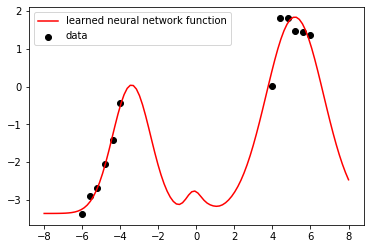

In [8]:
x_test = np.linspace(-8, 8, 100)

#predict on x_test
y_test = nn.forward(nn.weights, x_test.reshape((1, -1)))

#visualize our learned model
plt.scatter(x, y, color='black', label='data')
plt.plot(x_test, y_test.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

## Example of Fitting One Polynomial Regression Model to the Data

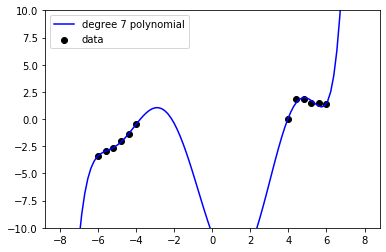

In [9]:
#set up for polynomial (deg 7) regression
linear_model = LinearRegression()
poly = PolynomialFeatures(7)

#fit a polynomial model
x_poly = poly.fit_transform(x.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
linear_model.fit(x_poly, y)

#predict on x_test
y_test_poly = linear_model.predict(x_test_poly)

#visualize our learned model
plt.scatter(x, y, color='black', label='data')
plt.plot(x_test, y_test_poly.flatten(), color='blue', label='degree 7 polynomial')
plt.legend(loc='best')
plt.ylim([-10, 10])
plt.show()

## Fitting Multiple Models to the Data Through Bootstrapping and Random Restarts

In [10]:
##define normal log-likelihood with variance 0.5**2
output_noise = 0.5**2
log_likelihood = lambda y_actual, y_pred: -0.5 * np.log(2 * np.pi * output_noise) - 0.5 * ((y_actual.flatten() - y_pred.flatten())**2).sum() / output_noise

trials = 50

y_test_nn = []
y_test_poly = []
log_lkhd_nn = []
log_lkhd_poly = []

for i in range(trials):
    if i % 10 == 0:
        print('trial:', i)
        
    #generate a bootstrap sample from the data
    indices = np.random.choice(np.arange(len(x)), size=len(x))
    bootstrap_x = x[indices]
    bootstrap_y = y[indices]
    
    #fit neural network
    ###define design choices in gradient descent
    random = np.random.RandomState(i)
    params = {'step_size':1e-3, 
              'max_iteration':3000, 
              'random_restarts':1, 
              'check_point':3000,
              'init': random.normal(0, 1, size=nn.weights.shape)
              }

    #fit my neural network to minimize MSE on the given data
    nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)
    #predict on x_test
    y_test = nn.forward(nn.weights, x_test.reshape((1, -1))).flatten()
    y_test_nn.append(y_test)
    
    #compute log likelihood on observed data
    y_train = nn.forward(nn.weights, x.reshape((1, -1))).flatten()
    log_lkhd_nn.append(log_likelihood(bootstrap_y, y_train))
    
    #fit a polynomial model
    bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
    bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    linear_model.fit(bootstrap_x_poly, bootstrap_y)

    #predict on x_test
    y_test = linear_model.predict(x_test_poly)
    y_test_poly.append(y_test)
    
    #compute log likelihood on observed data
    y_train = linear_model.predict(bootstrap_x_poly)
    log_lkhd_poly.append(log_likelihood(bootstrap_y, y_train.flatten()))

trial: 0
trial: 10
trial: 20
trial: 30
trial: 40


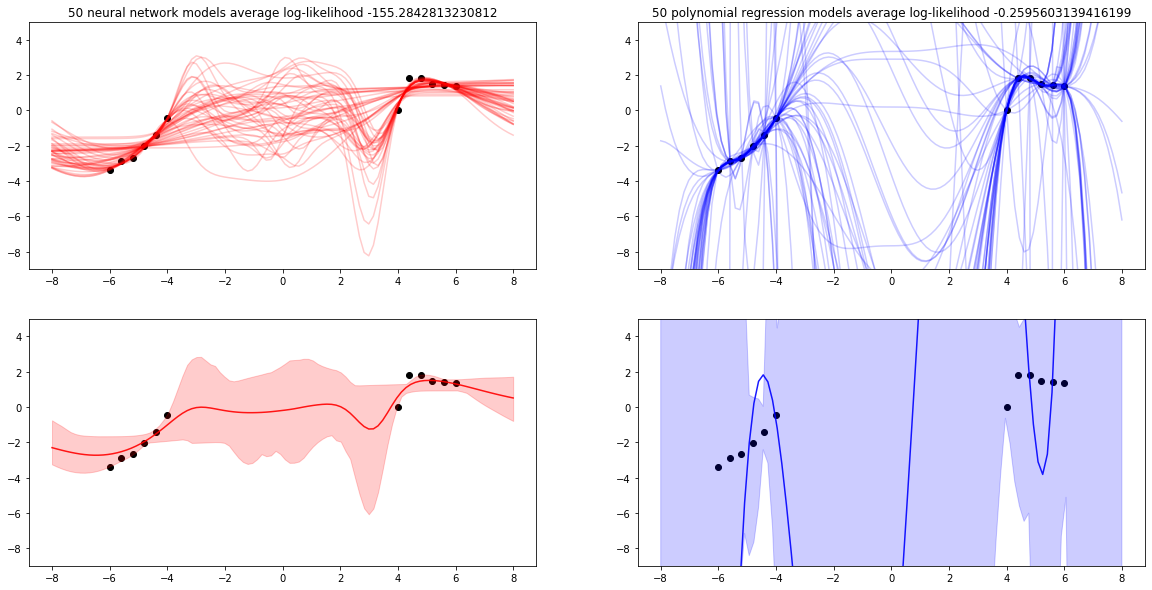

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].scatter(x, y, color='black', label='data')
ax[0, 1].scatter(x, y, color='black', label='data')
ax[1, 0].scatter(x, y, color='black', label='data')
ax[1, 1].scatter(x, y, color='black', label='data')

#plot the 50 neural network and polynomial models
for y_nn, y_poly in zip(y_test_nn, y_test_poly):
    ax[0, 0].plot(x_test, y_nn.flatten(), color='red', alpha=0.2)
    ax[0, 1].plot(x_test, y_poly, color='blue', alpha=0.2)

#compute 95% predictive interval
y_test_nn = np.array(y_test_nn)
y_test_poly = np.array(y_test_poly)

y_test_nn_ub = np.percentile(y_test_nn, 97.5, axis=0)
y_test_nn_mean = y_test_nn.mean(axis=0)
y_test_nn_lb = np.percentile(y_test_nn, 2.5, axis=0)

y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)
y_test_poly_mean = y_test_poly.mean(axis=0)
y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

#plot 95% predictive interval
ax[1, 0].fill_between(x_test, y_test_nn_ub, y_test_nn_lb, color='red', alpha=0.2)
ax[1, 1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
ax[1, 0].plot(x_test, y_test_nn_mean, color='red', alpha=0.9)
ax[1, 1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)
ax[1, 0].set_ylim([-9, 5])
ax[1, 1].set_ylim([-9, 5])

ax[0, 0].set_title('{} neural network models average log-likelihood {}'.format(trials, np.mean(log_lkhd_nn)))
ax[0, 1].set_title('{} polynomial regression models average log-likelihood {}'.format(trials, np.mean(log_lkhd_poly)))
ax[0, 0].set_ylim([-9, 5])
ax[0, 1].set_ylim([-9, 5])
plt.show()

### Part II. "Large" Data Set
Using the data that is generated by the code provided below.

1. (**Learning the Model**) Fit 100 different MLE neural network models (with the given architecture or your own choice) on this data. Bootstrap from the data as well as initialize your network parameters randomly for each fit. <br><br>

2. (**Model Evaluation**) Compute the average log-likelihood of the observed data over these 1000 MLE models.<br><br>

3. (**Model Evaluation**) Visualize the predictive distributions of your 1000 MLE models (i.e. use them to predict on a range of uniformly spaced values from [-11, 11] and then plot either the 95% predictive interval or plot all the models as lines).<br><br>

4. (**Compare with Polynomial Regression**) Do the above for polynomial models with polynomial degree 7. Which model class (polynomial or neural network) is a better fit for the data? Which model class produces better aleotoric uncertainty? Which model class prodcues better epistemic uncertainty? Why?

## Example of Fitting One NN to the Data

In [18]:
## generate training data
#number of points in each of the two segments of the domain
N = 100
#training x
x = np.hstack((np.linspace(-10, -5, N), np.linspace(5, 10, N)))
#output noise variance
y_var = 1.0
#function relating x and y
f = lambda x:  0.01 * x**3
#y is equal to f(x) plus gaussian noise
y = f(x) + np.random.normal(0, y_var**0.5, 2 * N)

In [20]:
###define design choices in gradient descent
params = {'step_size':1e-2, 
          'max_iteration':5000, 
          'random_restarts':1,
          'check_point': 200}

#fit my neural network to minimize MSE on the given data
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

Iteration 200 lower bound 235.79624100899485; gradient mag: 9.024782233130294
Iteration 400 lower bound 230.10382556454368; gradient mag: 7.599406953596322
Iteration 600 lower bound 225.15999271471992; gradient mag: 6.288451078653309
Iteration 800 lower bound 221.26226390870283; gradient mag: 5.3314368503935565
Iteration 1000 lower bound 218.25364028042998; gradient mag: 4.609745609708375
Iteration 1200 lower bound 215.88744162234156; gradient mag: 4.036980819690466
Iteration 1400 lower bound 213.95885303462904; gradient mag: 3.5534700979106146
Iteration 1600 lower bound 212.54609820397292; gradient mag: 3.0911603442344737
Iteration 1800 lower bound 211.39725357380127; gradient mag: 530.5125118361777
Iteration 2000 lower bound 210.40066092839123; gradient mag: 2.7307529809175555
Iteration 2200 lower bound 209.5659401850809; gradient mag: 34.28048132578321
Iteration 2400 lower bound 208.81161070606106; gradient mag: 8.17587082384065
Iteration 2600 lower bound 208.1825708177094; gradient

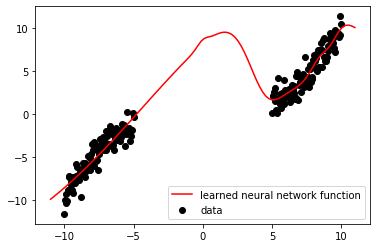

In [21]:
x_test = np.linspace(-11, 11, 100)

#predict on x_test
y_test = nn.forward(nn.weights, x_test.reshape((1, -1)))

#visualize our learned model
plt.scatter(x, y, color='black', label='data')
plt.plot(x_test, y_test.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

## Example of Fitting One Polynomial Regression Model to the Data

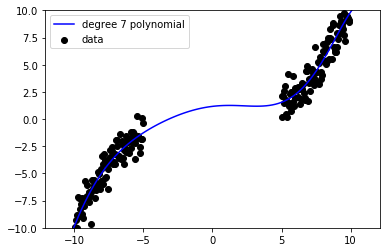

In [22]:
#set up for polynomial (deg 7) regression
linear_model = LinearRegression()
poly = PolynomialFeatures(7)

#fit a polynomial model
x_poly = poly.fit_transform(x.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
linear_model.fit(x_poly, y)

#predict on x_test
y_test_poly = linear_model.predict(x_test_poly)

#visualize our learned model
plt.scatter(x, y, color='black', label='data')
plt.plot(x_test, y_test_poly.flatten(), color='blue', label='degree 7 polynomial')
plt.legend(loc='best')
plt.ylim([-10, 10])
plt.show()

In [23]:
##define normal log-likelihood with variance 0.5**2
output_noise = 0.5**2
log_likelihood = lambda y_actual, y_pred: -0.5 * np.log(2 * np.pi * output_noise) - 0.5 * ((y_actual.flatten() - y_pred.flatten())**2).sum() / output_noise

trials = 50

y_test_nn = []
y_test_poly = []
log_lkhd_nn = []
log_lkhd_poly = []

for i in range(trials):
    if i % 10 == 0:
        print('trial:', i)
        
    #generate a bootstrap sample from the data
    indices = np.random.choice(np.arange(len(x)), size=len(x))
    bootstrap_x = x[indices]
    bootstrap_y = y[indices]
    
    #fit neural network
    ###define design choices in gradient descent
    random = np.random.RandomState(i)
    params = {'step_size':1e-3, 
              'max_iteration':3000, 
              'random_restarts':1, 
              'check_point':3000,
              'init': random.normal(0, 1, size=nn.weights.shape)
              }

    #fit my neural network to minimize MSE on the given data
    nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)
    #predict on x_test
    y_test = nn.forward(nn.weights, x_test.reshape((1, -1))).flatten()
    y_test_nn.append(y_test)
    
    #compute log likelihood on observed data
    y_train = nn.forward(nn.weights, x.reshape((1, -1))).flatten()
    log_lkhd_nn.append(log_likelihood(bootstrap_y, y_train))
    
    #fit a polynomial model
    bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
    bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    linear_model.fit(bootstrap_x_poly, bootstrap_y)

    #predict on x_test
    y_test = linear_model.predict(x_test_poly)
    y_test_poly.append(y_test)
    
    #compute log likelihood on observed data
    y_train = linear_model.predict(bootstrap_x_poly)
    log_lkhd_poly.append(log_likelihood(bootstrap_y, y_train.flatten()))

trial: 0
trial: 10
trial: 20
trial: 30
trial: 40


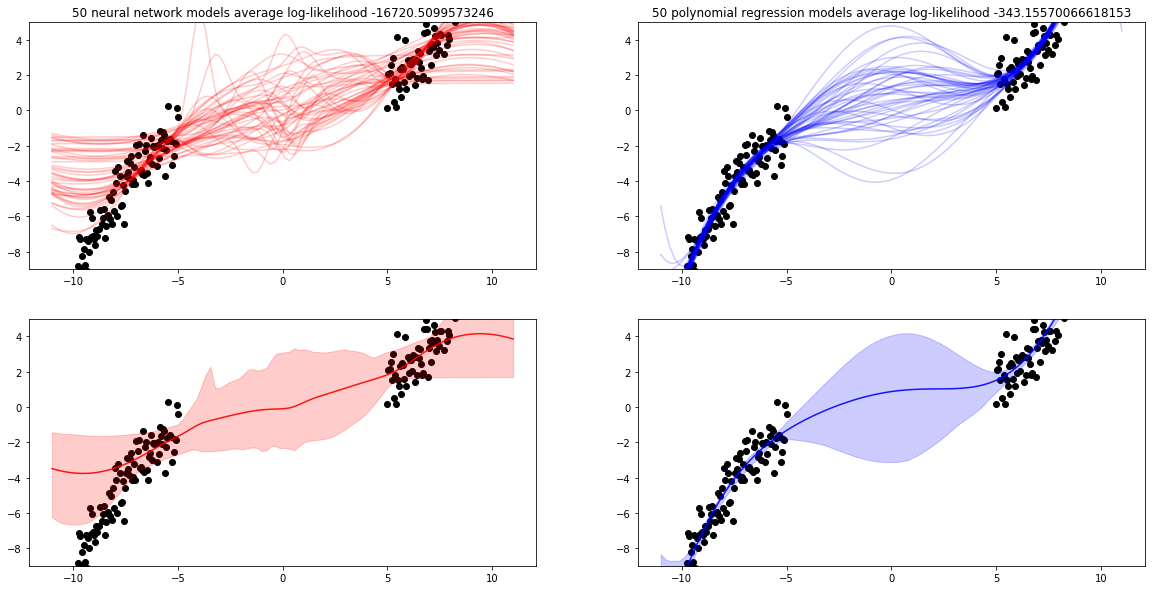

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].scatter(x, y, color='black', label='data')
ax[0, 1].scatter(x, y, color='black', label='data')
ax[1, 0].scatter(x, y, color='black', label='data')
ax[1, 1].scatter(x, y, color='black', label='data')

#plot the 50 neural network and polynomial models
for y_nn, y_poly in zip(y_test_nn, y_test_poly):
    ax[0, 0].plot(x_test, y_nn.flatten(), color='red', alpha=0.2)
    ax[0, 1].plot(x_test, y_poly, color='blue', alpha=0.2)

#compute 95% predictive interval
y_test_nn = np.array(y_test_nn)
y_test_poly = np.array(y_test_poly)

y_test_nn_ub = np.percentile(y_test_nn, 97.5, axis=0)
y_test_nn_mean = y_test_nn.mean(axis=0)
y_test_nn_lb = np.percentile(y_test_nn, 2.5, axis=0)

y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)
y_test_poly_mean = y_test_poly.mean(axis=0)
y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

#plot 95% predictive interval
ax[1, 0].fill_between(x_test, y_test_nn_ub, y_test_nn_lb, color='red', alpha=0.2)
ax[1, 1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
ax[1, 0].plot(x_test, y_test_nn_mean, color='red', alpha=0.9)
ax[1, 1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)
ax[1, 0].set_ylim([-9, 5])
ax[1, 1].set_ylim([-9, 5])

ax[0, 0].set_title('{} neural network models average log-likelihood {}'.format(trials, np.mean(log_lkhd_nn)))
ax[0, 1].set_title('{} polynomial regression models average log-likelihood {}'.format(trials, np.mean(log_lkhd_poly)))
ax[0, 0].set_ylim([-9, 5])
ax[0, 1].set_ylim([-9, 5])
plt.show()